In [1]:
!pip install imblearn
!pip install xgboost 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 166.7 MB 8.1 kB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

%matplotlib inline

In [2]:
import os 
os.chdir("../")
bucket = 'aws-project-politomaster-sagemaker-data' 

In [3]:
prep_train_path = os.path.join('s3://', bucket, 'preprocess/prep_train.csv')
prep_train = pd.read_csv(prep_train_path)
print("Prep_train dataset has: {} rows and {} columns".format(prep_train.shape[0], prep_train.shape[1]))
prep_train.head()

Prep_train dataset has: 43170 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


In [4]:
prep_test_path = os.path.join('s3://', bucket, 'preprocess/prep_test.csv')
prep_test = pd.read_csv(prep_test_path)
print("Prep_test dataset has: {} rows and {} columns".format(prep_test.shape[0], prep_test.shape[1]))
prep_train.head()

Prep_test dataset has: 10770 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


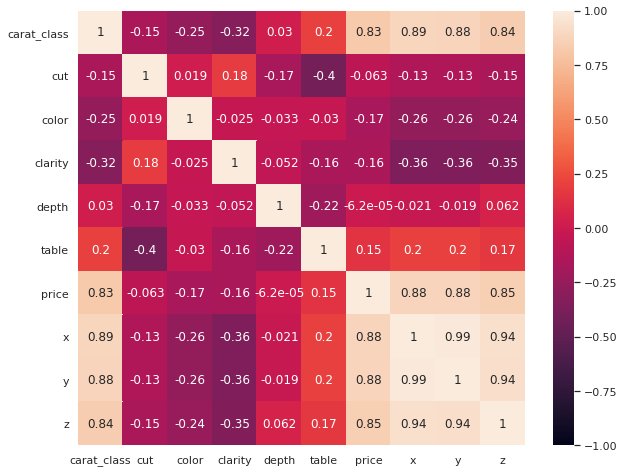

In [5]:
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(prep_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [6]:
def categorize_x(x):
    to_return = None
    if x < 7:
        to_return = "low"
    elif x < 9:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

def categorize_y(y):
    to_return = None
    if y < 6:
        to_return = "low"
    elif y < 8:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

In [7]:
from sklearn.base import BaseEstimator,TransformerMixin

class CustomTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        print('\n')
        
    def fit(self,X,y=None):
        #print('\n>>>>>>>fit() called.\n')
        return self
    
    def transform(self,X,y=None):
        #print('\n>>>>>>>transform() called.\n')
        X_ = X.copy()

        X_['x_cat'] = X_['x'].apply(lambda x : categorize_x(x)).astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
        X_['y_cat'] = X_['y'].apply(lambda y : categorize_y(y)).astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
        
        return X_
        

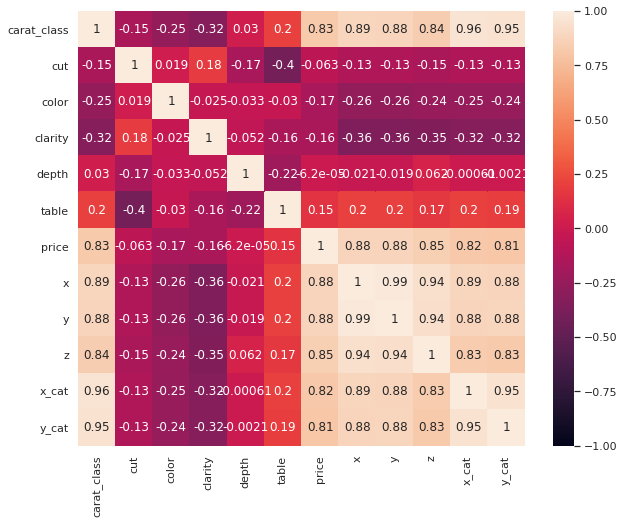

In [8]:
custom_transf = CustomTransformer()
new_train = custom_transf.transform(prep_train)

sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(new_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [15]:
seed = 0

target = prep_train['carat_class']
data = prep_train.drop(labels = ['carat_class'],axis = 1)
sample_train, sample_val, label_train, label_val = \
    train_test_split(data, target, test_size=0.3, random_state=seed)

In [16]:
classifiers = [RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(),
                MLPClassifier(), XGBClassifier(use_label_encoder=False)
              ]

clf_names = ['Random forest', 'ADAboost', 'GBT', 'MLP',
             'XGBoost']

sampling_techs = [EditedNearestNeighbours(), RandomOverSampler(), SMOTE(random_state=seed)]
sampling_names = ['ENN-Undersample', 'ROS-Oversample','SMOTE']



Classifier:  Random forest
Sampling method:  ENN-Undersample
Time required:  5.930563926696777
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.96      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



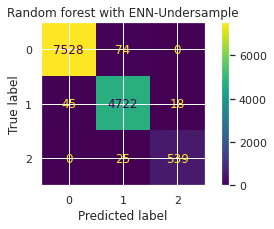



Classifier:  Random forest
Sampling method:  ROS-Oversample
Time required:  8.849397897720337
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.98      0.99      0.99      4785
           2       0.97      0.94      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



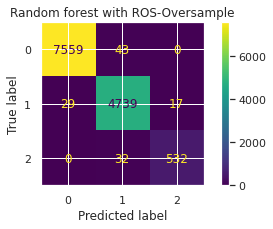



Classifier:  Random forest
Sampling method:  SMOTE
Time required:  11.526232481002808
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.99      0.99      4785
           2       0.94      0.96      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



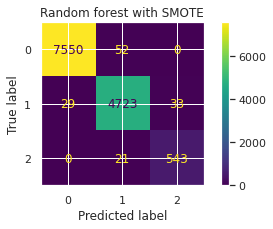



Classifier:  ADAboost
Sampling method:  ENN-Undersample
Time required:  3.3555920124053955
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.96      0.97      4785
           2       0.81      0.97      0.88       564

    accuracy                           0.98     12951
   macro avg       0.93      0.98      0.95     12951
weighted avg       0.98      0.98      0.98     12951



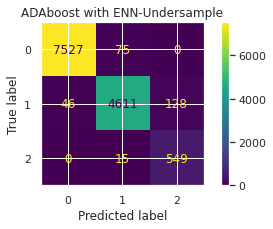



Classifier:  ADAboost
Sampling method:  ROS-Oversample
Time required:  3.809150218963623
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.88      0.99      0.93      4785
           2       1.00      0.00      0.01       564

    accuracy                           0.95     12951
   macro avg       0.96      0.66      0.64     12951
weighted avg       0.95      0.95      0.93     12951



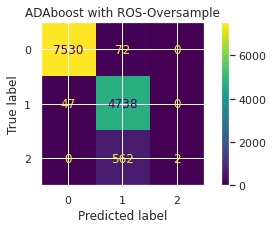



Classifier:  ADAboost
Sampling method:  SMOTE
Time required:  4.954376459121704
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      7602
           1       0.63      0.85      0.72      4785
           2       0.14      0.18      0.16       564

    accuracy                           0.76     12951
   macro avg       0.59      0.59      0.58     12951
weighted avg       0.82      0.76      0.77     12951



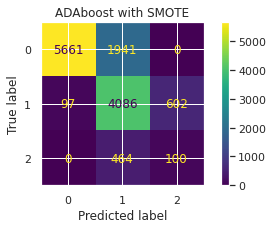



Classifier:  GBT
Sampling method:  ENN-Undersample
Time required:  30.802231073379517
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.94      0.96      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



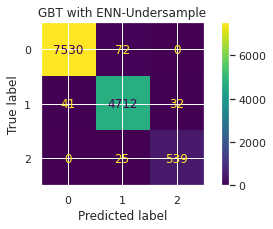



Classifier:  GBT
Sampling method:  ROS-Oversample
Time required:  46.899423360824585
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.99      0.99      4785
           2       0.94      0.97      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



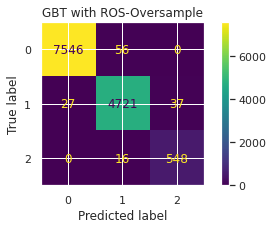



Classifier:  GBT
Sampling method:  SMOTE
Time required:  58.26597619056702
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.92      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



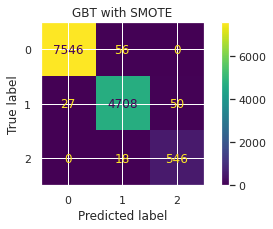



Classifier:  MLP
Sampling method:  ENN-Undersample
Time required:  14.069236040115356
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.95      0.97      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



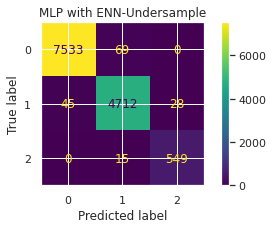



Classifier:  MLP
Sampling method:  ROS-Oversample
Time required:  53.62146615982056
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.99      0.99      0.99      4785
           2       0.96      0.97      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



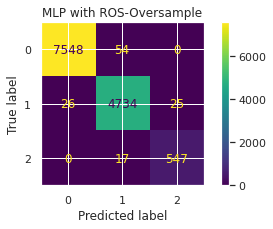



Classifier:  MLP
Sampling method:  SMOTE
Time required:  57.05022668838501
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.99      0.99      0.99      4785
           2       0.94      0.97      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



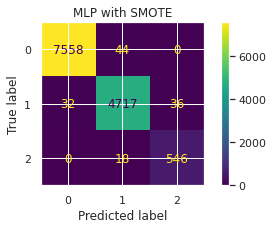



[16:58:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier:  XGBoost
Sampling method:  ENN-Undersample
Time required:  6.3279032707214355
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.96      0.96      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



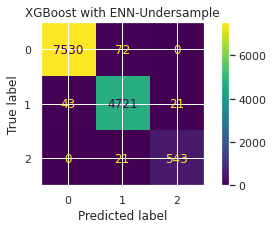



[16:58:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier:  XGBoost
Sampling method:  ROS-Oversample
Time required:  13.070164680480957
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.99      0.99      0.99      4785
           2       0.96      0.97      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



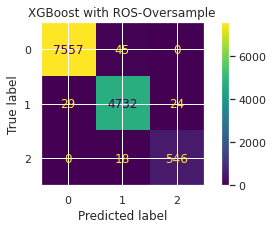



[16:58:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier:  XGBoost
Sampling method:  SMOTE
Time required:  17.843367099761963
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.99      0.99      0.99      4785
           2       0.94      0.97      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



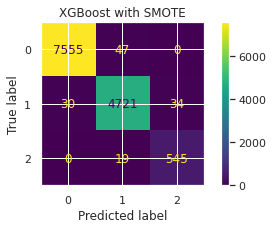

0.9819940452947794 XGBoost ROS-Oversample


In [17]:
best_f1 = 0
best_clf = ''
best_samp = ''
for clf, clf_name in zip(classifiers,clf_names):
    for samp, samp_name in zip(sampling_techs,sampling_names):
        custom_transf = CustomTransformer()
        std_scale = StandardScaler()
        pca = PCA(n_components=8)
        
        t0 = time.time()
        model = make_pipeline(custom_transf,std_scale,pca,samp,clf)
        model.fit(sample_train, label_train)
        pred = model.predict(sample_val)
        t1 = time.time()
        f1 = f1_score(label_val,pred,average = 'macro')
        if f1 > best_f1:
            best_f1 = f1
            best_clf = clf_name
            best_samp = samp_name
        print('Classifier: ',clf_name)
        print('Sampling method: ',samp_name)
        print('Time required: ',t1-t0)
        print(classification_report(label_val,pred))
        img = sns.set(rc={'figure.figsize':(6,3)})
        plot_confusion_matrix(model, sample_val, label_val) 
        plt.title(clf_name + ' with '+samp_name)
        plt.show()
        
print(best_f1, best_clf, best_samp)